In [1]:
#pandas libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import sklearn.model_selection as modsel
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import math

%run "../notebooks/cargar_df.ipynb"

In [2]:
train = get_train()

In [3]:
test = get_test()

In [4]:
train = train[train.Stage.isin(['Closed Won', 'Closed Lost'])].copy()
train.shape

(16883, 47)

In [5]:
train.Stage.value_counts()

Closed Won     9533
Closed Lost    7350
Name: Stage, dtype: int64

In [6]:
# Me quedo con los registros con la oportunidad terminada
train.Stage.replace({'Closed Won': 1, 'Closed Lost': 0}, inplace=True)

In [7]:
train.Stage.value_counts()

1    9533
0    7350
Name: Stage, dtype: int64

In [8]:
X = pd.DataFrame({'Opportunity_ID':train.Opportunity_ID.unique()})

In [9]:
# Hago lo mismo con test
testX = pd.DataFrame({'Opportunity_ID':test.Opportunity_ID.unique()})

Busco registros que tengan la misma opportunity id para saber cuales son
las columnas que pueden cambiar el valor

In [10]:
b = train.groupby('Opportunity_ID').ID.count() > 1
b = b[b] # Dejo solo los trues
df = train[train.Opportunity_ID.isin(b.index)]
df

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Account_Created_Date,Source,...,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage
8,24353,Japan,None,1,0,0,0,Bureaucratic_Code_5,2015-04-20,None,...,2016-02-29,2016-02-01,Q1,2016,0,JPY,15600.0,JPY,470400.0,0
9,24355,Japan,None,1,0,0,0,Bureaucratic_Code_5,2015-04-20,None,...,2016-02-29,2016-02-01,Q1,2016,0,JPY,4400.0,JPY,470400.0,0
10,24356,Japan,None,1,0,0,0,Bureaucratic_Code_5,2015-04-20,None,...,2016-02-29,2016-02-01,Q1,2016,0,JPY,6200.0,JPY,470400.0,0
11,24357,Japan,None,1,0,0,0,Bureaucratic_Code_5,2015-04-20,None,...,2016-02-29,2016-02-01,Q1,2016,0,JPY,140000.0,JPY,470400.0,0
12,24358,Japan,None,1,0,0,0,Bureaucratic_Code_5,2015-04-20,None,...,2016-02-29,2016-02-01,Q1,2016,0,JPY,304200.0,JPY,470400.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16940,20827,Americas,NE America,1,0,0,0,Bureaucratic_Code_5,2014-06-16,None,...,2016-12-30,2016-10-01,Q4,2016,20,USD,10751580.0,USD,21332500.0,0
16941,20830,Americas,NE America,1,0,0,0,Bureaucratic_Code_5,2014-06-16,None,...,2016-12-30,2016-10-01,Q4,2016,20,USD,10580920.0,USD,21332500.0,0
16942,8781,EMEA,Austria,1,1,1,1,Bureaucratic_Code_4,2016-01-15,Source_7,...,2016-03-25,2016-03-01,Q1,2016,0,EUR,103350.0,EUR,299715.0,1
16943,8786,EMEA,Austria,1,1,1,1,Bureaucratic_Code_4,2016-01-15,Source_7,...,2016-04-08,2016-04-01,Q2,2016,0,EUR,93015.0,EUR,299715.0,1


In [11]:
print('Columnas que cambian de valor dependiendo de la Id en train')

size = df.Opportunity_ID.unique().size
diff_columns = []
for column in df.columns:
    if (df.groupby('Opportunity_ID')[column].value_counts().count() != size):
        diff_columns.append(column)
diff_columns

Columnas que cambian de valor dependiendo de la Id en train


['ID',
 'Product_Family',
 'Product_Name',
 'ASP',
 'ASP_(converted)',
 'Planned_Delivery_Start_Date',
 'Planned_Delivery_End_Date',
 'Month',
 'Delivery_Quarter',
 'Delivery_Year',
 'TRF',
 'Total_Amount']

In [12]:
print('Columnas que cambian de valor dependiendo de la Id en test')

size = test.Opportunity_ID.unique().size
diff_columns = []
for column in test.columns:
    if (test.groupby('Opportunity_ID')[column].value_counts().count() != size):
        diff_columns.append(column)
diff_columns

Columnas que cambian de valor dependiendo de la Id en test


['ID',
 'Product_Family',
 'Product_Name',
 'ASP',
 'ASP_(converted)',
 'Planned_Delivery_Start_Date',
 'Planned_Delivery_End_Date',
 'Month',
 'Delivery_Quarter',
 'Delivery_Year',
 'TRF',
 'Total_Amount']

In [13]:
train.columns

Index(['ID', 'Region', 'Territory', 'Pricing, Delivery_Terms_Quote_Appr',
       'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval',
       'Bureaucratic_Code_0_Approved', 'Bureaucratic_Code',
       'Account_Created_Date', 'Source ', 'Billing_Country', 'Account_Name',
       'Opportunity_Name', 'Opportunity_ID', 'Sales_Contract_No',
       'Account_Owner', 'Opportunity_Owner', 'Account_Type',
       'Opportunity_Type', 'Quote_Type', 'Delivery_Terms',
       'Opportunity_Created_Date', 'Brand', 'Product_Type', 'Size',
       'Product_Category_B', 'Price', 'Currency', 'Quote_Expiry_Date',
       'Last_Modified_Date', 'Last_Modified_By', 'Product_Family',
       'Product_Name', 'ASP_Currency', 'ASP', 'ASP_(converted)',
       'Planned_Delivery_Start_Date', 'Planned_Delivery_End_Date', 'Month',
       'Delivery_Quarter', 'Delivery_Year', 'TRF', 'Total_Amount_Currency',
       'Total_Amount', 'Total_Taxable_Amount_Currency', 'Total_Taxable_Amount',
       'Stage'],
      dt

In [14]:
grouped_train = train.groupby('Opportunity_ID').agg(\
    {'Region':'first',
     'Territory':'first',
     'Pricing, Delivery_Terms_Quote_Appr':'first',
     'Pricing, Delivery_Terms_Approved':'first',
     'Bureaucratic_Code_0_Approval':'first',
     'Bureaucratic_Code_0_Approved':'first',
     'Bureaucratic_Code':'first',
     'Account_Created_Date':'first',
     'Billing_Country':'first',
     'Account_Name':'first',
     'Opportunity_Name':'first',
     'Sales_Contract_No':'first',
     'Account_Owner':'first',
     'Opportunity_Owner':'first',
     'Account_Type':'first',
     'Opportunity_Type':'first',
     'Quote_Type':'first',
     'Delivery_Terms':'first',
     'Opportunity_Created_Date':'first',
     'Brand':'first',
     'Product_Type':'first',
     'Size':'first',
     'Product_Category_B':'first',
     'Price':'first',
     'Currency':'first',
     'Quote_Expiry_Date':'first',
     'Last_Modified_Date':'first',
     'Last_Modified_By':'first',
     'ASP_Currency':'first',
     'Total_Amount_Currency':'first',
     'Total_Taxable_Amount_Currency':'first',
     'Total_Taxable_Amount':'first',
     'Stage':'first'}).reset_index()
grouped_train

,Opportunity_ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Account_Created_Date,Billing_Country,...,Price,Currency,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,ASP_Currency,Total_Amount_Currency,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage
0,0,EMEA,None,1,1,1,1,Bureaucratic_Code_4,2015-06-16,Netherlands,...,None,None,1/30/2016,2016-06-13,Person_Name_18,EUR,EUR,EUR,5272800.0,0
1,1,EMEA,None,0,0,0,0,Bureaucratic_Code_4,2015-06-16,Netherlands,...,None,None,1/20/2016,2016-01-15,Person_Name_20,EUR,EUR,EUR,48230.0,1
2,2,Americas,NW America,0,0,0,0,Bureaucratic_Code_4,2015-04-21,United States,...,None,None,9/30/2016,2016-09-29,Person_Name_8,USD,USD,USD,83865.6,1
3,3,Americas,NW America,1,0,1,0,Bureaucratic_Code_5,2013-07-27,United States,...,0.42,USD,NaT,2018-03-27,Person_Name_8,USD,USD,USD,7421881.5,0
4,4,Americas,NW America,1,0,1,0,Bureaucratic_Code_5,2013-07-27,United States,...,0.42,USD,6/2/2017,2018-03-27,Person_Name_8,USD,USD,USD,13357192.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9786,12799,EMEA,Norway,1,1,0,0,Bureaucratic_Code_4,2013-07-27,Germany,...,None,None,4/3/2016,2016-04-01,Person_Name_13,EUR,EUR,EUR,401700.0,1
9787,12800,Americas,NE America,1,0,0,0,Bureaucratic_Code_5,2014-06-16,Germany,...,None,None,1/15/2016,2016-10-10,Person_Name_13,USD,USD,USD,21332500.0,0
9788,12801,EMEA,Austria,1,1,1,1,Bureaucratic_Code_4,2016-01-15,Austria,...,None,None,NaT,2016-01-19,Person_Name_13,EUR,EUR,EUR,299715.0,1
9789,12802,Americas,NE America,1,1,1,1,Bureaucratic_Code_4,2015-10-20,United States,...,None,None,2/29/2016,2016-01-22,Person_Name_3,USD,USD,USD,0.0,0


In [15]:
y = train.groupby('Opportunity_ID').Stage.first()

In [16]:
grouped_test = test.groupby('Opportunity_ID').agg(\
    {'Region':'first', 'Territory':'first',
     'Pricing, Delivery_Terms_Quote_Appr':'first',
     'Pricing, Delivery_Terms_Approved':'first',
     'Bureaucratic_Code_0_Approval':'first',
     'Bureaucratic_Code_0_Approved':'first',
     'Bureaucratic_Code':'first',
     'Account_Created_Date':'first',
     'Billing_Country':'first',
     'Account_Name':'first',
     'Opportunity_Name':'first',
     'Sales_Contract_No':'first',
     'Account_Owner':'first',
     'Opportunity_Owner':'first',
     'Account_Type':'first',
     'Opportunity_Type':'first',
     'Quote_Type':'first',
     'Delivery_Terms':'first',
     'Opportunity_Created_Date':'first',
     'Brand':'first',
     'Product_Type':'first',
     'Size':'first',
     'Product_Category_B':'first',
     'Price':'first',
     'Currency':'first',
     'Quote_Expiry_Date':'first',
     'Last_Modified_Date':'first',
     'Last_Modified_By':'first',
     'ASP_Currency':'first',
     'Total_Amount_Currency':'first',
     'Total_Taxable_Amount_Currency':'first',
     'Total_Taxable_Amount':'first'}).reset_index()
grouped_test

,Opportunity_ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Account_Created_Date,Billing_Country,...,Product_Category_B,Price,Currency,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,ASP_Currency,Total_Amount_Currency,Total_Taxable_Amount_Currency,Total_Taxable_Amount
0,10689,EMEA,Germany,1,1,1,1,Bureaucratic_Code_4,2017-07-05,Germany,...,None,None,None,4/30/2019,2019-04-12,Person_Name_13,EUR,EUR,EUR,367419.0
1,10690,EMEA,Germany,1,1,1,1,Bureaucratic_Code_4,2017-07-05,Germany,...,None,None,None,4/30/2019,2019-04-25,Person_Name_13,EUR,EUR,EUR,757783.5
2,10691,Americas,NE America,1,1,0,0,Bureaucratic_Code_4,2019-02-16,United States,...,None,None,None,NaT,2019-04-16,Person_Name_9,USD,USD,USD,21037.5
3,10692,Americas,NW America,1,1,1,0,Bureaucratic_Code_2,2013-07-27,United States,...,None,None,None,NaT,2019-04-16,Person_Name_8,USD,USD,USD,2169106.5
4,10693,Americas,NW America,0,0,0,0,Bureaucratic_Code_4,2018-08-30,United States,...,None,None,None,5/12/2019,2019-04-13,Person_Name_64,USD,USD,USD,5752.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,12364,EMEA,KSA,1,1,0,0,Bureaucratic_Code_4,2017-06-12,South Africa,...,None,None,None,5/24/2019,2019-04-26,Person_Name_13,USD,USD,USD,147750.0
1563,12365,Americas,SE America,1,1,0,0,Bureaucratic_Code_4,2018-06-08,United States,...,None,None,None,5/24/2019,2019-04-27,Person_Name_38,USD,USD,USD,45054.9
1564,12366,Americas,SE America,1,1,1,1,Bureaucratic_Code_4,2018-06-08,United States,...,None,None,None,5/24/2019,2019-04-27,Person_Name_38,USD,USD,USD,100122.0
1565,12367,Americas,NE America,1,1,0,0,Bureaucratic_Code_4,2018-08-29,United States,...,None,None,None,5/26/2019,2019-04-26,Person_Name_9,USD,USD,USD,143220.0


#### Las columnas Datetime son:

    Account_Created_Date
    Opportunity_Created_Date
    Quote_Expiry_Date
    Last_Modified_Date

#### Cambian segun Id:
    Planned_Delivery_Start_Date
    Planned_Delivery_End_Date
    Month
    Delivery_Quarter
    Delivery_Year

In [17]:
df = pd.DataFrame({'Opportunity_ID': grouped_train.Opportunity_ID})
df

,Opportunity_ID
0,0
1,1
2,2
3,3
4,4
...,...
9786,12799
9787,12800
9788,12801
9789,12802


In [61]:
# Features de Account_Created_Date
df['Account_Created_Date_day'] = grouped_train.Account_Created_Date.dt.day
df['Account_Created_Date_month'] = grouped_train.Account_Created_Date.dt.month
df['Account_Created_Date_year'] = grouped_train.Account_Created_Date.dt.year
df['Account_Created_Date_weekday'] = grouped_train.Account_Created_Date.dt.weekday
df['Account_Created_Date_weekyear'] = grouped_train.Account_Created_Date.dt.week
df['Account_Created_Date_dayyear'] = grouped_train.Account_Created_Date.dt.dayofyear

/home/cecilia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [62]:
# Features de Opportunity_Created_Date
df['Opportunity_Created_Date_day'] = grouped_train.Opportunity_Created_Date.dt.day
df['Opportunity_Created_Date_month'] = grouped_train.Opportunity_Created_Date.dt.month
df['Opportunity_Created_Date_year'] = grouped_train.Opportunity_Created_Date.dt.year
df['Opportunity_Created_Date_weekday'] = grouped_train.Opportunity_Created_Date.dt.weekday
df['Opportunity_Created_Date_weekyear'] = grouped_train.Opportunity_Created_Date.dt.week
df['Opportunity_Created_Date_dayyear'] = grouped_train.Opportunity_Created_Date.dt.dayofyear

/home/cecilia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [69]:
df.isna().sum()

Opportunity_ID                       0
Account_Created_Date_day             0
Account_Created_Date_month           0
Account_Created_Date_year            0
Account_Created_Date_weekday         0
Account_Created_Date_weekyear        0
Account_Created_Date_dayyear         0
Opportunity_Created_Date_day         0
Opportunity_Created_Date_month       0
Opportunity_Created_Date_year        0
Opportunity_Created_Date_weekday     0
Opportunity_Created_Date_weekyear    0
Opportunity_Created_Date_dayyear     0
dtype: int64

In [80]:
# Features de Last_Modified_Date

df['Last_Modified_Date_acc_days'] = (grouped_train.Last_Modified_Date \
    - grouped_train.Account_Created_Date).dt.days
df['Last_Modified_Date_opp_days'] = (grouped_train.Last_Modified_Date \
    - grouped_train.Opportunity_Created_Date).dt.days

In [100]:
grouped_train.Quote_Expiry_Date.value_counts()

NaT           2328
6/30/2017      259
3/31/2017      231
12/31/2016     148
9/30/2017      138
              ... 
1/14/2016        1
10/9/2018        1
1/19/2019        1
12/26/2016       1
11/25/2018       1
Name: Quote_Expiry_Date, Length: 996, dtype: int64

In [110]:
mask_train = grouped_train.Quote_Expiry_Date.agg(lambda x: x != 'NaT')
mask_test = grouped_test.Quote_Expiry_Date.agg(lambda x: x != 'NaT')

In [147]:
df_dates = grouped_train.loc[mask_train]
df_dates = df_dates.append(grouped_test.loc[mask_test])
df_dates

,Opportunity_ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Account_Created_Date,Billing_Country,...,Price,Currency,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,ASP_Currency,Total_Amount_Currency,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage
0,0,EMEA,None,1,1,1,1,Bureaucratic_Code_4,2015-06-16,Netherlands,...,None,None,1/30/2016,2016-06-13,Person_Name_18,EUR,EUR,EUR,5272800.0,0.0
1,1,EMEA,None,0,0,0,0,Bureaucratic_Code_4,2015-06-16,Netherlands,...,None,None,1/20/2016,2016-01-15,Person_Name_20,EUR,EUR,EUR,48230.0,1.0
2,2,Americas,NW America,0,0,0,0,Bureaucratic_Code_4,2015-04-21,United States,...,None,None,9/30/2016,2016-09-29,Person_Name_8,USD,USD,USD,83865.6,1.0
4,4,Americas,NW America,1,0,1,0,Bureaucratic_Code_5,2013-07-27,United States,...,0.42,USD,6/2/2017,2018-03-27,Person_Name_8,USD,USD,USD,13357192.5,0.0
5,5,Americas,NW America,1,0,1,0,Bureaucratic_Code_5,2013-07-27,United States,...,0.42,USD,6/2/2017,2018-03-27,Person_Name_8,USD,USD,USD,14838277.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,12364,EMEA,KSA,1,1,0,0,Bureaucratic_Code_4,2017-06-12,South Africa,...,None,None,5/24/2019,2019-04-26,Person_Name_13,USD,USD,USD,147750.0,NaN
1563,12365,Americas,SE America,1,1,0,0,Bureaucratic_Code_4,2018-06-08,United States,...,None,None,5/24/2019,2019-04-27,Person_Name_38,USD,USD,USD,45054.9,NaN
1564,12366,Americas,SE America,1,1,1,1,Bureaucratic_Code_4,2018-06-08,United States,...,None,None,5/24/2019,2019-04-27,Person_Name_38,USD,USD,USD,100122.0,NaN
1565,12367,Americas,NE America,1,1,0,0,Bureaucratic_Code_4,2018-08-29,United States,...,None,None,5/26/2019,2019-04-26,Person_Name_9,USD,USD,USD,143220.0,NaN


In [153]:
df_dates.Quote_Expiry_Date = df_dates.Quote_Expiry_Date.astype('datetime64')

In [165]:
Quote_Expiry_Date_acc_mean = math.floor((df_dates.Quote_Expiry_Date \
    - df_dates.Account_Created_Date).dt.days.mean())
Quote_Expiry_Date_acc_mean

768

In [166]:
Quote_Expiry_Date_opp_mean = math.floor((df_dates.Quote_Expiry_Date \
    - df_dates.Opportunity_Created_Date).dt.days.mean())
Quote_Expiry_Date_opp_mean

52

In [171]:
grouped_train.Quote_Expiry_Date = grouped_train.Quote_Expiry_Date.astype('datetime64')

In [218]:
def func_date_acc_mean(x, y):
    if (x != 'NaT'):
        return x - y
    return 'NaT'


In [220]:
(grouped_train.Quote_Expiry_Date.isna()).sum()

2328

In [227]:
grouped_train.agg(lambda x: \
                  func_date_acc_mean(x.Quote_Expiry_Date, x.Account_Created_Date), axis=1)\
.dt.days.where(mask_train, Quote_Expiry_Date_acc_mean)

0        228.0
1        218.0
2        528.0
3        768.0
4       1406.0
         ...  
9786     981.0
9787     578.0
9788     768.0
9789     132.0
9790     125.0
Length: 9791, dtype: float64

In [228]:
grouped_train.agg(lambda x: \
                  func_date_acc_mean(x.Quote_Expiry_Date, x.Opportunity_Created_Date), axis=1)\
.dt.days.where(mask_train, Quote_Expiry_Date_opp_mean)

0        54.0
1        44.0
2       297.0
3        52.0
4       542.0
        ...  
9786    121.0
9787     42.0
9788     52.0
9789     86.0
9790     32.0
Length: 9791, dtype: float64

In [229]:
# Features de Quote_Expiry_Date

df['Quote_Expiry_Date_acc_days'] = grouped_train.agg(lambda x: \
                  func_date_acc_mean(x.Quote_Expiry_Date, x.Account_Created_Date), axis=1)\
                  .dt.days.where(mask_train, Quote_Expiry_Date_acc_mean)
df['Quote_Expiry_Date_opp_days'] = grouped_train.agg(lambda x: \
                  func_date_acc_mean(x.Quote_Expiry_Date, x.Opportunity_Created_Date), axis=1)\
                  .dt.days.where(mask_train, Quote_Expiry_Date_opp_mean)

In [230]:
df

,Opportunity_ID,Account_Created_Date_day,Account_Created_Date_month,Account_Created_Date_year,Account_Created_Date_weekday,Account_Created_Date_weekyear,Account_Created_Date_dayyear,Opportunity_Created_Date_day,Opportunity_Created_Date_month,Opportunity_Created_Date_year,Opportunity_Created_Date_weekday,Opportunity_Created_Date_weekyear,Opportunity_Created_Date_dayyear,Last_Modified_Date_acc_days,Last_Modified_Date_opp_days,Quote_Expiry_Date_acc_days,Quote_Expiry_Date_opp_days
0,0,16,6,2015,1,25,167,7,12,2015,0,50,341,363,189,228.0,54.0
1,1,16,6,2015,1,25,167,7,12,2015,0,50,341,213,39,218.0,44.0
2,2,21,4,2015,1,17,111,8,12,2015,1,50,342,527,296,528.0,297.0
3,3,27,7,2013,5,30,208,8,12,2015,1,50,342,1704,840,768.0,52.0
4,4,27,7,2013,5,30,208,8,12,2015,1,50,342,1704,840,1406.0,542.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9786,12799,27,7,2013,5,30,208,4,12,2015,4,49,338,979,119,981.0,121.0
9787,12800,16,6,2014,0,25,167,4,12,2015,4,49,338,847,311,578.0,42.0
9788,12801,15,1,2016,4,2,15,4,12,2015,4,49,338,4,46,768.0,52.0
9789,12802,20,10,2015,1,43,293,5,12,2015,5,49,339,94,48,132.0,86.0


In [231]:
train.Planned_Delivery_Start_Date.value_counts().isna().sum()

0

In [232]:
test.Planned_Delivery_Start_Date.value_counts().isna().sum()

0

In [233]:
train.Planned_Delivery_End_Date.value_counts().isna().sum()

0

In [234]:
test.Planned_Delivery_End_Date.value_counts().isna().sum()

0

In [293]:
delivery_dates = train.groupby('Opportunity_ID').agg(\
    {'Planned_Delivery_Start_Date':['max','min'],
     'Planned_Delivery_End_Date':['max','min']}).reset_index()
delivery_dates

Opportunity_ID Planned_Delivery_Start_Date             \
                                            max        min   
0                 0                  2016-05-01 2016-05-01   
1                 1                  2016-01-18 2016-01-18   
2                 2                  2016-01-25 2016-01-25   
3                 3                  2018-02-01 2018-02-01   
4                 4                  2018-02-01 2018-02-01   
...             ...                         ...        ...   
9786          12799                  2016-04-01 2016-04-01   
9787          12800                  2016-10-03 2016-10-03   
9788          12801                  2016-04-04 2016-03-21   
9789          12802                  2016-04-25 2016-04-25   
9790          12803                  2016-07-01 2016-07-01   

     Planned_Delivery_End_Date             
                           max        min  
0                   2016-06-30 2016-06-30  
1                   2016-01-20 2016-01-20  
2                   2016-01-25 2016-01-25  
3                   2018-03-31 2018-03-31  
4                   2018-02-28 2018-02-28  
...                        ...        ...  
9786                2016-04-21 2016-04-21  
9787                2016-12-30 2016-12-30  
9788                2016-04-08 2016-03-25  
9789                2016-04-29 2016-04-29  
9790                2016-08-31 2016-08-31  

[9791 rows x 5 columns]

In [294]:
(delivery_dates['Planned_Delivery_Start_Date']['min'] == \
delivery_dates['Planned_Delivery_Start_Date']['max']).sum()

9008

In [295]:
delivery_dates.shape

(9791, 5)

In [296]:
(delivery_dates['Planned_Delivery_End_Date']['min'] == \
delivery_dates['Planned_Delivery_End_Date']['max']).sum()

8920

Agrego dos columnas binarias:
    Si el minimo y el maximo de la fecha de entrega difiere

In [244]:
(delivery_dates['Planned_Delivery_Start_Date']['min'] != \
delivery_dates['Planned_Delivery_Start_Date']['max']).astype('int8')

Opportunity_ID
0        0
1        0
2        0
3        0
4        0
        ..
12799    0
12800    0
12801    1
12802    0
12803    0
Length: 9791, dtype: int8

In [299]:
df['Planned_Delivery_Start_Min!=Max'] = \
   (delivery_dates['Planned_Delivery_Start_Date']['min'] != \
   delivery_dates['Planned_Delivery_Start_Date']['max']).astype('int8')

df['Planned_Delivery_End_Min!=Max'] = \
   (delivery_dates['Planned_Delivery_End_Date']['min'] != \
   delivery_dates['Planned_Delivery_End_Date']['max']).astype('int8')

In [268]:
(delivery_dates['Planned_Delivery_Start_Date']['min'] != \
   delivery_dates['Planned_Delivery_Start_Date']['max']).astype('int8').value_counts()

0    9008
1     783
dtype: int64

In [246]:
df

,Opportunity_ID,Account_Created_Date_day,Account_Created_Date_month,Account_Created_Date_year,Account_Created_Date_weekday,Account_Created_Date_weekyear,Account_Created_Date_dayyear,Opportunity_Created_Date_day,Opportunity_Created_Date_month,Opportunity_Created_Date_year,Opportunity_Created_Date_weekday,Opportunity_Created_Date_weekyear,Opportunity_Created_Date_dayyear,Last_Modified_Date_acc_days,Last_Modified_Date_opp_days,Quote_Expiry_Date_acc_days,Quote_Expiry_Date_opp_days,Planned_Delivery_Start_Min!=Max,Planned_Delivery_End_Min!=Max
0,0,16,6,2015,1,25,167,7,12,2015,0,50,341,363,189,228.0,54.0,0.0,0.0
1,1,16,6,2015,1,25,167,7,12,2015,0,50,341,213,39,218.0,44.0,0.0,0.0
2,2,21,4,2015,1,17,111,8,12,2015,1,50,342,527,296,528.0,297.0,0.0,0.0
3,3,27,7,2013,5,30,208,8,12,2015,1,50,342,1704,840,768.0,52.0,0.0,0.0
4,4,27,7,2013,5,30,208,8,12,2015,1,50,342,1704,840,1406.0,542.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9786,12799,27,7,2013,5,30,208,4,12,2015,4,49,338,979,119,981.0,121.0,0.0,0.0
9787,12800,16,6,2014,0,25,167,4,12,2015,4,49,338,847,311,578.0,42.0,0.0,0.0
9788,12801,15,1,2016,4,2,15,4,12,2015,4,49,338,4,46,768.0,52.0,0.0,0.0
9789,12802,20,10,2015,1,43,293,5,12,2015,5,49,339,94,48,132.0,86.0,0.0,0.0


In [314]:
# Features de Planned_Delivery

# Rango de la entrega
df['Planned_Delivery_End-Start'] = (delivery_dates['Planned_Delivery_End_Date']['min'] - \
   delivery_dates['Planned_Delivery_Start_Date']['min']).dt.days

# Valores del dia, deberian ser los mismos valores que las columnas Month y Delivery_Year
df['Planned_Delivery_Start_Date_day'] = \
    delivery_dates.Planned_Delivery_Start_Date['min'].dt.day
df['Planned_Delivery_Start_Date_month'] = \
    delivery_dates.Planned_Delivery_Start_Date['min'].dt.month
df['Planned_Delivery_Start_Date_year'] = \
    delivery_dates.Planned_Delivery_Start_Date['min'].dt.year
df['Planned_Delivery_Start_Date_weekday'] = \
    delivery_dates.Planned_Delivery_Start_Date['min'].dt.weekday
df['Planned_Delivery_Start_Date_weekyear'] = \
    delivery_dates.Planned_Delivery_Start_Date['min'].dt.week
df['Planned_Delivery_Start_Date_dayyear'] = \
    delivery_dates.Planned_Delivery_Start_Date['min'].dt.dayofyear

/home/cecilia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [248]:
(delivery_dates['Planned_Delivery_End_Date']['min'] - \
   delivery_dates['Planned_Delivery_Start_Date']['min']).dt.days

Opportunity_ID
0        60.0
1         2.0
2         0.0
3        58.0
4        27.0
         ... 
12799    20.0
12800    88.0
12801     4.0
12802     4.0
12803    61.0
Name: min, Length: 9791, dtype: float64

In [249]:
df

,Opportunity_ID,Account_Created_Date_day,Account_Created_Date_month,Account_Created_Date_year,Account_Created_Date_weekday,Account_Created_Date_weekyear,Account_Created_Date_dayyear,Opportunity_Created_Date_day,Opportunity_Created_Date_month,Opportunity_Created_Date_year,...,Quote_Expiry_Date_opp_days,Planned_Delivery_Start_Min!=Max,Planned_Delivery_End_Min!=Max,Planned_Delivery_End-Start,Planned_Delivery_Start_Date_day,Planned_Delivery_Start_Date_month,Planned_Delivery_Start_Date_year,Planned_Delivery_Start_Date_weekday,Planned_Delivery_Start_Date_weekyear,Planned_Delivery_Start_Date_dayyear
0,0,16,6,2015,1,25,167,7,12,2015,...,54.0,0.0,0.0,60.0,1.0,5.0,2016.0,6.0,17.0,122.0
1,1,16,6,2015,1,25,167,7,12,2015,...,44.0,0.0,0.0,2.0,18.0,1.0,2016.0,0.0,3.0,18.0
2,2,21,4,2015,1,17,111,8,12,2015,...,297.0,0.0,0.0,0.0,25.0,1.0,2016.0,0.0,4.0,25.0
3,3,27,7,2013,5,30,208,8,12,2015,...,52.0,0.0,0.0,58.0,1.0,2.0,2018.0,3.0,5.0,32.0
4,4,27,7,2013,5,30,208,8,12,2015,...,542.0,0.0,0.0,27.0,1.0,2.0,2018.0,3.0,5.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9786,12799,27,7,2013,5,30,208,4,12,2015,...,121.0,0.0,0.0,4.0,3.0,12.0,2018.0,0.0,49.0,337.0
9787,12800,16,6,2014,0,25,167,4,12,2015,...,42.0,0.0,0.0,40.0,21.0,10.0,2018.0,6.0,42.0,294.0
9788,12801,15,1,2016,4,2,15,4,12,2015,...,52.0,0.0,0.0,9.0,1.0,11.0,2018.0,3.0,44.0,305.0
9789,12802,20,10,2015,1,43,293,5,12,2015,...,86.0,0.0,0.0,30.0,1.0,12.0,2018.0,5.0,48.0,335.0


In [315]:
df.isna().sum()

Account_Created_Date_day                 0
Account_Created_Date_month               0
Account_Created_Date_year                0
Account_Created_Date_weekday             0
Account_Created_Date_weekyear            0
Account_Created_Date_dayyear             0
Opportunity_Created_Date_day             0
Opportunity_Created_Date_month           0
Opportunity_Created_Date_year            0
Opportunity_Created_Date_weekday         0
Opportunity_Created_Date_weekyear        0
Opportunity_Created_Date_dayyear         0
Last_Modified_Date_acc_days              0
Last_Modified_Date_opp_days              0
Quote_Expiry_Date_acc_days               0
Quote_Expiry_Date_opp_days               0
Planned_Delivery_Start_Min!=Max          0
Planned_Delivery_End_Min!=Max            0
Planned_Delivery_End-Start              57
Planned_Delivery_Start_Date_day          0
Planned_Delivery_Start_Date_month        0
Planned_Delivery_Start_Date_year         0
Planned_Delivery_Start_Date_weekday      0
Planned_Del

In [325]:
mean_delivery_diff = math.floor(df['Planned_Delivery_End-Start'].mean())
mean_delivery_diff

22

In [338]:
df['Planned_Delivery_End-Start'].fillna(mean_delivery_diff, inplace=True)

In [303]:
# Features de Planned_Delivery

df['Planned_Delivery_Start_Date_acc_days'] = (delivery_dates.Planned_Delivery_Start_Date['min'] \
    - grouped_train.Account_Created_Date).dt.days
df['Planned_Delivery_Start_Date_opp_days'] = (delivery_dates.Planned_Delivery_Start_Date['min'] \
    - grouped_train.Opportunity_Created_Date).dt.days

In [251]:
df

,Opportunity_ID,Account_Created_Date_day,Account_Created_Date_month,Account_Created_Date_year,Account_Created_Date_weekday,Account_Created_Date_weekyear,Account_Created_Date_dayyear,Opportunity_Created_Date_day,Opportunity_Created_Date_month,Opportunity_Created_Date_year,...,Planned_Delivery_End_Min!=Max,Planned_Delivery_End-Start,Planned_Delivery_Start_Date_day,Planned_Delivery_Start_Date_month,Planned_Delivery_Start_Date_year,Planned_Delivery_Start_Date_weekday,Planned_Delivery_Start_Date_weekyear,Planned_Delivery_Start_Date_dayyear,Planned_Delivery_Start_Date_acc_days,Planned_Delivery_Start_Date_opp_days
0,0,16,6,2015,1,25,167,7,12,2015,...,0.0,60.0,1.0,5.0,2016.0,6.0,17.0,122.0,320.0,146.0
1,1,16,6,2015,1,25,167,7,12,2015,...,0.0,2.0,18.0,1.0,2016.0,0.0,3.0,18.0,216.0,42.0
2,2,21,4,2015,1,17,111,8,12,2015,...,0.0,0.0,25.0,1.0,2016.0,0.0,4.0,25.0,279.0,48.0
3,3,27,7,2013,5,30,208,8,12,2015,...,0.0,58.0,1.0,2.0,2018.0,3.0,5.0,32.0,1650.0,786.0
4,4,27,7,2013,5,30,208,8,12,2015,...,0.0,27.0,1.0,2.0,2018.0,3.0,5.0,32.0,1650.0,786.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9786,12799,27,7,2013,5,30,208,4,12,2015,...,0.0,4.0,3.0,12.0,2018.0,0.0,49.0,337.0,1955.0,1095.0
9787,12800,16,6,2014,0,25,167,4,12,2015,...,0.0,40.0,21.0,10.0,2018.0,6.0,42.0,294.0,1588.0,1052.0
9788,12801,15,1,2016,4,2,15,4,12,2015,...,0.0,9.0,1.0,11.0,2018.0,3.0,44.0,305.0,1021.0,1063.0
9789,12802,20,10,2015,1,43,293,5,12,2015,...,0.0,30.0,1.0,12.0,2018.0,5.0,48.0,335.0,1138.0,1092.0


In [365]:
import random

s = pd.Series('Random')

for i in range (0, df.Opportunity_ID.size):
    s[i] = random.randint(0,999)
s

0       421
1       742
2       240
3       209
4        32
       ... 
9786    670
9787    649
9788    349
9789    450
9790    638
Length: 9791, dtype: object

In [369]:
df['Random'] = s.astype('int64')

In [254]:
trainX = df.copy().drop(['Opportunity_ID'], axis=1)

In [367]:
trainX

,Account_Created_Date_day,Account_Created_Date_month,Account_Created_Date_year,Account_Created_Date_weekday,Account_Created_Date_weekyear,Account_Created_Date_dayyear,Opportunity_Created_Date_day,Opportunity_Created_Date_month,Opportunity_Created_Date_year,Opportunity_Created_Date_weekday,...,Planned_Delivery_End-Start,Planned_Delivery_Start_Date_day,Planned_Delivery_Start_Date_month,Planned_Delivery_Start_Date_year,Planned_Delivery_Start_Date_weekday,Planned_Delivery_Start_Date_weekyear,Planned_Delivery_Start_Date_dayyear,Planned_Delivery_Start_Date_acc_days,Planned_Delivery_Start_Date_opp_days,Random
0,16,6,2015,1,25,167,7,12,2015,0,...,60.0,1,5,2016,6,17,122,320,146,421
1,16,6,2015,1,25,167,7,12,2015,0,...,2.0,18,1,2016,0,3,18,216,42,742
2,21,4,2015,1,17,111,8,12,2015,1,...,0.0,25,1,2016,0,4,25,279,48,240
3,27,7,2013,5,30,208,8,12,2015,1,...,58.0,1,2,2018,3,5,32,1650,786,209
4,27,7,2013,5,30,208,8,12,2015,1,...,27.0,1,2,2018,3,5,32,1650,786,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9786,27,7,2013,5,30,208,4,12,2015,4,...,20.0,1,4,2016,4,13,92,979,119,670
9787,16,6,2014,0,25,167,4,12,2015,4,...,88.0,3,10,2016,0,40,277,840,304,649
9788,15,1,2016,4,2,15,4,12,2015,4,...,4.0,21,3,2016,0,12,81,66,108,349
9789,20,10,2015,1,43,293,5,12,2015,5,...,4.0,25,4,2016,0,17,116,188,142,450


In [408]:
# Calculo el error
X_train, X_test, y_train, y_test = \
    train_test_split(trainX, y, test_size=0.2, random_state=123)

rf_reg = RandomForestRegressor(n_estimators=100)
rf_reg.fit(X_train, y_train)
preds = rf_reg.predict(X_test)
ll = log_loss(y_test, preds, normalize=True)
print("Log Loss: %f" % (ll))

Log Loss: 0.399080


In [409]:
# Feature importances
rf_reg.feature_importances_

array([0.02952815, 0.01969466, 0.04020536, 0.02981048, 0.02313676,
       0.02811063, 0.0205538 , 0.01693809, 0.05072321, 0.01936758,
       0.02155148, 0.02686894, 0.03072739, 0.03824418, 0.02621908,
       0.02900265, 0.06227619, 0.02723022, 0.10085159, 0.02881711,
       0.01622636, 0.03180323, 0.02326328, 0.02450155, 0.02494337,
       0.04373183, 0.14702956, 0.01864334], dtype=float32)

In [412]:
p = pd.DataFrame({'feature':X_train.columns, 'value':rf_reg.feature_importances_})

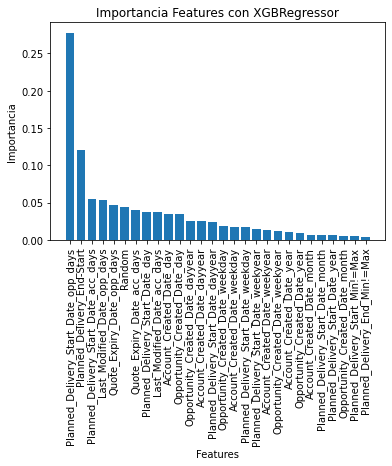

In [413]:
g = p.sort_values('value').nlargest(50, 'value')

plt.bar(g.feature, g.value, )
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.ylabel('Importancia')
plt.title('Importancia Features con Random Forest')
plt.show()

Me quedo con los 5 features mas importantes

In [415]:
p.sort_values('value').nlargest(5, 'value')

,feature,value
26,Planned_Delivery_Start_Date_opp_days,0.277814
18,Planned_Delivery_End-Start,0.120427
25,Planned_Delivery_Start_Date_acc_days,0.054272
13,Last_Modified_Date_opp_days,0.053757
15,Quote_Expiry_Date_opp_days,0.046920


### Hago lo mismo para el set de test

In [416]:
df_test = pd.DataFrame({'Opportunity_ID': grouped_test.Opportunity_ID})

In [417]:
# Features de Last_Modified_Date

df_test['Last_Modified_Date_opp_days'] = (grouped_test.Last_Modified_Date \
    - grouped_test.Opportunity_Created_Date).dt.days

In [418]:
grouped_test.Quote_Expiry_Date = grouped_test.Quote_Expiry_Date.astype('datetime64')

In [420]:
# Features de Quote_Expiry_Date

df_test['Quote_Expiry_Date_opp_days'] = grouped_test.agg(lambda x: \
                  func_date_acc_mean(x.Quote_Expiry_Date, x.Opportunity_Created_Date), axis=1)\
                  .dt.days.where(mask_test, Quote_Expiry_Date_opp_mean)

In [421]:
delivery_dates_test = test.groupby('Opportunity_ID').agg(\
    {'Planned_Delivery_Start_Date':['max','min'],
     'Planned_Delivery_End_Date':['max','min']}).reset_index()
delivery_dates_test

Opportunity_ID Planned_Delivery_Start_Date             \
                                            max        min   
0             10689                  2019-05-01 2019-05-01   
1             10690                  2019-06-01 2019-06-01   
2             10691                  2019-10-01 2019-10-01   
3             10692                  2019-12-16 2019-12-02   
4             10693                  2019-05-02 2019-05-02   
...             ...                         ...        ...   
1562          12364                  2019-05-01 2019-05-01   
1563          12365                  2019-10-01 2019-10-01   
1564          12366                  2019-10-01 2019-10-01   
1565          12367                  2019-08-01 2019-08-01   
1566          12368                  2019-10-21 2019-10-21   

     Planned_Delivery_End_Date             
                           max        min  
0                   2019-05-31 2019-05-31  
1                   2019-06-29 2019-06-28  
2                   2019-10-01 2019-10-01  
3                   2019-12-16 2019-12-02  
4                   2019-05-02 2019-05-02  
...                        ...        ...  
1562                2019-05-10 2019-05-10  
1563                2019-12-31 2019-12-31  
1564                2019-12-31 2019-12-31  
1565                2019-08-01 2019-08-01  
1566                2019-12-13 2019-12-13  

[1567 rows x 5 columns]

In [422]:
# Features de Planned_Delivery

# Rango de la entrega
df_test['Planned_Delivery_End-Start'] = (delivery_dates_test['Planned_Delivery_End_Date']['min'] - \
   delivery_dates_test['Planned_Delivery_Start_Date']['min']).dt.days

In [423]:
df_test.isna().sum()

Opportunity_ID                  0
Last_Modified_Date_opp_days     0
Quote_Expiry_Date_opp_days      0
Planned_Delivery_End-Start     43
dtype: int64

In [424]:
df_test['Planned_Delivery_End-Start'].fillna(mean_delivery_diff, inplace=True)

In [425]:
# Features de Planned_Delivery

df_test['Planned_Delivery_Start_Date_acc_days'] = (delivery_dates_test.Planned_Delivery_Start_Date['min'] \
    - grouped_test.Account_Created_Date).dt.days
df_test['Planned_Delivery_Start_Date_opp_days'] = (delivery_dates_test.Planned_Delivery_Start_Date['min'] \
    - grouped_test.Opportunity_Created_Date).dt.days

### Guardo en archivos

In [427]:
df_test

,Opportunity_ID,Last_Modified_Date_opp_days,Quote_Expiry_Date_opp_days,Planned_Delivery_End-Start,Planned_Delivery_Start_Date_acc_days,Planned_Delivery_Start_Date_opp_days
0,10689,0,18.0,30.0,665,19
1,10690,13,18.0,27.0,696,50
2,10691,4,52.0,0.0,227,172
3,10692,4,52.0,0.0,2319,234
4,10693,1,30.0,0.0,245,20
...,...,...,...,...,...,...
1562,12364,0,28.0,9.0,688,5
1563,12365,1,28.0,91.0,480,158
1564,12366,1,28.0,91.0,480,158
1565,12367,0,30.0,0.0,337,97


In [439]:
df_test.to_csv('../files_csv/features_fechas_test.csv', index=False)

In [430]:
trainX[['Last_Modified_Date_opp_days', \
       'Quote_Expiry_Date_opp_days', 'Planned_Delivery_End-Start', \
       'Planned_Delivery_Start_Date_acc_days', 'Planned_Delivery_Start_Date_opp_days']]

,Last_Modified_Date_opp_days,Quote_Expiry_Date_opp_days,Planned_Delivery_End-Start,Planned_Delivery_Start_Date_acc_days,Planned_Delivery_Start_Date_opp_days
0,189,54.0,60.0,320,146
1,39,44.0,2.0,216,42
2,296,297.0,0.0,279,48
3,840,52.0,58.0,1650,786
4,840,542.0,27.0,1650,786
...,...,...,...,...,...
9786,119,121.0,20.0,979,119
9787,311,42.0,88.0,840,304
9788,46,52.0,4.0,66,108
9789,48,86.0,4.0,188,142


In [435]:
pd.concat([grouped_train.Opportunity_ID, trainX[['Last_Modified_Date_opp_days', \
       'Quote_Expiry_Date_opp_days', 'Planned_Delivery_End-Start', \
       'Planned_Delivery_Start_Date_acc_days', 'Planned_Delivery_Start_Date_opp_days']]], \
        axis=1)

,Opportunity_ID,Last_Modified_Date_opp_days,Quote_Expiry_Date_opp_days,Planned_Delivery_End-Start,Planned_Delivery_Start_Date_acc_days,Planned_Delivery_Start_Date_opp_days
0,0,189,54.0,60.0,320,146
1,1,39,44.0,2.0,216,42
2,2,296,297.0,0.0,279,48
3,3,840,52.0,58.0,1650,786
4,4,840,542.0,27.0,1650,786
...,...,...,...,...,...,...
9786,12799,119,121.0,20.0,979,119
9787,12800,311,42.0,88.0,840,304
9788,12801,46,52.0,4.0,66,108
9789,12802,48,86.0,4.0,188,142


In [440]:
pd.concat([grouped_train.Opportunity_ID, trainX[['Last_Modified_Date_opp_days', \
       'Quote_Expiry_Date_opp_days', 'Planned_Delivery_End-Start', \
       'Planned_Delivery_Start_Date_acc_days', 'Planned_Delivery_Start_Date_opp_days']]], \
        axis=1).to_csv('../files_csv/features_fechas_train.csv', index=False)